In [1]:
from lifelong_forests import *

In [3]:
import pickle
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def homogenize_labels(a):
    u = np.unique(a)
    return np.array([np.where(u == i)[0][0] for i in a])

In [4]:
train_file = 'cifar-100-python/train'
unpickled_train = unpickle(train_file)
train_keys = list(unpickled_train.keys())
fine_labels = np.array(unpickled_train[train_keys[2]])

train_data = unpickled_train[list(train_keys)[-1]]
class_idx = [np.where(fine_labels == u)[0] for u in np.unique(fine_labels)]

n_tasks = 10 # should divide 100 evenly
K = int(len(class_idx)/n_tasks)

train_by_task = [np.concatenate(class_idx[i*n_tasks: (i+1)*n_tasks]) for i in range(n_tasks)]

n_trees = int(np.sqrt(len(class_idx[0])))

test_file = 'cifar-100-python/test'
unpickled_test = unpickle(test_file)
test_keys = list(unpickled_test.keys())
test_labels = np.array(unpickled_test[test_keys[2]])

test_data = unpickled_test[test_keys[-1]]
test_class_idx = [np.where(test_labels == u)[0] for u in np.unique(test_labels)]
test_by_task = [np.concatenate(test_class_idx[i*n_tasks: (i+1)*n_tasks]) for i in range(n_tasks)]

In [88]:
np.random.seed(1)

mc_its = 10
all_models = [[] for i in range(mc_its)]

for j in range(mc_its):
    for i, u in enumerate(range(n_tasks)):
        X = train_data[np.concatenate(class_idx[i*n_tasks: (i+1)*n_tasks])]
        labels = np.concatenate([n_tasks*i*np.ones(500) + j for j in range(n_tasks*i, n_tasks*(i+1))])
        model = build_model(X, labels, n_trees)
        all_models[j].append(model)

In [8]:
# qa_check = np.zeros((n_tasks, 1000, K))
# i = 0
# X = train_data[np.concatenate(class_idx[i*n_tasks: (i+1)*n_tasks])]
# labels = np.concatenate([i*n_tasks*np.ones(500) + j for j in range(n_tasks*i, n_tasks*(i+1))])

# for i in range(qa_check.shape[0]):
#     if i == 0:
#         qa_check[i] = estimate_posteriors(models[i], X, labels, test_data[test_by_task[0]], in_task=True, subsample=0.32)
#     else:
#         qa_check[i] = estimate_posteriors(models[i], X, labels, test_data[test_by_task[0]], in_task=False, subsample=0.32)

# qa_avg = np.mean(qa_check, axis = 0)
# print(qa_avg.shape)
# print(np.sum(predict(qa_avg) == test_labels[test_by_task[0]]) / len(test_by_task[0]))

In [6]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble.forest import _generate_sample_indices

def estimate_posteriors(model, train, y, test, in_task=True, subsample=1, acorn=None):
    if acorn is None:
        acorn = np.random.randint(10**6)
    np.random.seed(acorn)

    n, d = train.shape
    m, d_ = test.shape

    if d != d_:
        raise ValueError("train and test data in different dimensions")

    class_counts = np.zeros((m, model.n_classes_))
    unique_labels = np.unique(y)
    def _map(u, x):
        return np.where(u == x)[0][0]
    
    for tree in model:
        # get out of bag indicies
        if in_task:
            prob_indices = _generate_unsampled_indices(tree.random_state, n)
        else:
            prob_indices = np.random.choice(range(n), size=int(subsample*n), replace=False)
        
        leaf_nodes = get_leaves(tree)
        unique_leaf_nodes = np.unique(leaf_nodes)
            
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(unique_leaf_nodes), model.n_classes_))

        for prob_index in prob_indices:
            temp_node = tree.apply(train[prob_index].reshape(1, -1)).item()
            posterior_class_counts[np.where(unique_leaf_nodes == temp_node)[0][0], _map(unique_labels, y[prob_index])] += 1
            
        # total number of points in a node
        row_sums = posterior_class_counts.sum(axis=1)
        
        # no divide by zero
        row_sums[row_sums == 0] = 1

        # posteriors
        class_probs = (posterior_class_counts / row_sums[:, None])
        # posteriors with finite sampling correction
        
        class_probs = finite_sample_correction(class_probs, row_sums)

        # posteriors as a list
        class_probs.tolist()
  
        partition_counts = np.asarray([node_counts[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts / class_counts.sum(axis=1, keepdims=True)

    return probs

In [94]:
all_etas = [np.array([np.zeros((n_tasks, n_tasks*100, K)) for i in range(n_tasks)]) for j in range(mc_its)]
subsample=1

for _ in tqdm(range(mc_its)):
    for i, test_set in enumerate(tqdm(test_by_task)):
        for j in tqdm(range(n_tasks)):
            if i == j:
                all_etas[_][i][j] = estimate_posteriors(all_models[_][i], 
                                train_data[np.array(train_by_task[j])], 
                                fine_labels[np.array(train_by_task[j])],
                                test_data[test_by_task[j]],
                                in_task = True,
                                subsample = subsample)

            else:
                all_etas[_][i][j] = estimate_posteriors(all_models[_][i], 
                                train_data[train_by_task[j]], 
                                fine_labels[train_by_task[j]],
                                test_data[test_by_task[j]],
                                in_task = False,
                                subsample = subsample)

                all_etas[_][j][i] = estimate_posteriors(all_models[_][j], 
                                train_data[train_by_task[i]], 
                                fine_labels[train_by_task[i]],
                                test_data[test_by_task[i]],
                                in_task = False,
                                subsample = subsample)


# etas = [np.zeros((n_tasks, n_tasks*100, K)) for i in range(n_tasks)]
# subsample=1

# for i, test_set in enumerate(test_by_task):
#     for j in range(n_tasks):
#         print(i,j)
#         if i == j:
#             etas[i][j] = estimate_posteriors(models[i], 
#                             train_data[np.array(train_by_task[j])], 
#                             fine_labels[np.array(train_by_task[j])],
#                             test_data[test_by_task[j]],
#                             in_task = True,
#                             subsample = subsample)
            
#         else:
#             etas[i][j] = estimate_posteriors(models[i], 
#                             train_data[train_by_task[j]], 
#                             fine_labels[train_by_task[j]],
#                             test_data[test_by_task[j]],
#                             in_task = False,
#                             subsample = subsample)
            
#             etas[j][i] = estimate_posteriors(models[j], 
#                             train_data[train_by_task[i]], 
#                             fine_labels[train_by_task[i]],
#                             test_data[test_by_task[i]],
#                             in_task = False,
#                             subsample = subsample)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

 20%|██        | 2/10 [00:17<00:50,  6.28s/it]

 30%|███       | 3/10 [00:33<01:05,  9.30s/it]

 40%|████      | 4/10 [00:55<01:17, 12.99s/it]

 50%|█████     | 5/10 [01:12<01:11, 14.21s/it]

 60%|██████    | 6/10 [01:29<01:00, 15.02s/it]

 70%|███████   | 7/10 [01:44<00:45, 15.14s/it]

 80%|████████  | 8/10 [02:01<00:31, 15.83s/it]

 90%|█████████ | 9/10 [02:19<00:16, 16.41s/it]

 10%|█         | 1/10 [02:35<23:23, 155.98s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:15<02:16, 15.11s/it]

 20%|██        | 2/10 [00:18<01:32, 11.62s/it]

 30%|███       | 3/10 [00:33<01:28, 12.59s/it]

 40%|████      | 4/10 [00:49<01:20, 13.49s/it]

 50%|█████     | 5/10 [01:04<01:10, 14.18s/it]

 60%|██████    | 6/10 [01:20<00:58, 14.61s/it]

 70%|███████   | 7/10 [01:36<00:45, 15.02s/it]

 80%|████████  | 8/10 [01:53<00:31, 15.51s/it]

 90%|█████████ 

 70%|███████   | 7/10 [03:47<01:43, 34.43s/it]

 80%|████████  | 8/10 [04:23<01:09, 34.84s/it]

 90%|█████████ | 9/10 [04:59<00:35, 35.23s/it]

 30%|███       | 3/10 [17:28<41:08, 352.58s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:36<05:24, 36.09s/it]

 20%|██        | 2/10 [01:12<04:49, 36.22s/it]

 30%|███       | 3/10 [01:48<04:13, 36.22s/it]

 40%|████      | 4/10 [01:56<02:46, 27.78s/it]

 50%|█████     | 5/10 [02:33<02:31, 30.39s/it]

 60%|██████    | 6/10 [03:10<02:09, 32.39s/it]

 70%|███████   | 7/10 [03:46<01:40, 33.62s/it]

 80%|████████  | 8/10 [04:23<01:09, 34.59s/it]

 90%|█████████ | 9/10 [05:00<00:35, 35.19s/it]

 40%|████      | 4/10 [23:06<34:48, 348.11s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:37<05:34, 37.22s/it]

 20%|██        | 2/10 [01:14<04:57, 37.13s/it]

 30%|███       | 3/10 [01:51<04:20, 37.21s/it]

 40%|████      | 4/10 [02:28<03:42, 37.09s/it]

 50%|█████     | 5/10 [02:36<02:21, 28.30s/it]

 60%|█

 40%|████      | 4/10 [02:25<03:38, 36.49s/it]

 50%|█████     | 5/10 [03:01<03:02, 36.42s/it]

 60%|██████    | 6/10 [03:09<01:51, 27.76s/it]

 70%|███████   | 7/10 [03:45<01:30, 30.22s/it]

 80%|████████  | 8/10 [04:21<01:04, 32.02s/it]

 90%|█████████ | 9/10 [04:57<00:33, 33.15s/it]

 60%|██████    | 6/10 [33:37<22:22, 335.75s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:37<05:34, 37.17s/it]

 20%|██        | 2/10 [01:13<04:55, 36.95s/it]

 30%|███       | 3/10 [01:49<04:17, 36.76s/it]

 40%|████      | 4/10 [02:26<03:40, 36.77s/it]

 50%|█████     | 5/10 [03:03<03:03, 36.76s/it]

 60%|██████    | 6/10 [03:40<02:26, 36.71s/it]

 70%|███████   | 7/10 [03:47<01:24, 28.02s/it]

 80%|████████  | 8/10 [04:24<01:01, 30.57s/it]

 90%|█████████ | 9/10 [05:00<00:32, 32.18s/it]

 70%|███████   | 7/10 [39:14<16:48, 336.04s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:36<05:31, 36.85s/it]

 20%|██        | 2/10 [01:13<04:53, 36.71s/it]

 30%|█

 10%|█         | 1/10 [00:18<02:49, 18.79s/it]

 20%|██        | 2/10 [00:35<02:25, 18.15s/it]

 30%|███       | 3/10 [00:53<02:05, 17.97s/it]

 40%|████      | 4/10 [01:09<01:45, 17.64s/it]

 50%|█████     | 5/10 [01:27<01:27, 17.58s/it]

 60%|██████    | 6/10 [01:46<01:12, 18.16s/it]

 70%|███████   | 7/10 [02:05<00:55, 18.42s/it]

 80%|████████  | 8/10 [02:24<00:37, 18.51s/it]

 90%|█████████ | 9/10 [02:28<00:14, 14.01s/it]

 90%|█████████ | 9/10 [42:49<03:47, 227.92s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:17<02:38, 17.60s/it]

 20%|██        | 2/10 [00:36<02:24, 18.10s/it]

 30%|███       | 3/10 [00:55<02:07, 18.25s/it]

 40%|████      | 4/10 [01:12<01:47, 17.98s/it]

 50%|█████     | 5/10 [01:30<01:28, 17.80s/it]

 60%|██████    | 6/10 [01:48<01:11, 17.96s/it]

 70%|███████   | 7/10 [02:04<00:51, 17.22s/it]

 80%|████████  | 8/10 [02:22<00:35, 17.50s/it]

 90%|█████████ | 9/10 [02:39<00:17, 17.39s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|  

 90%|█████████ | 9/10 [01:47<00:12, 12.53s/it]

 10%|█         | 1/10 [01:59<17:59, 119.99s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:13<01:57, 13.04s/it]

 20%|██        | 2/10 [00:15<01:19,  9.99s/it]

 30%|███       | 3/10 [00:28<01:16, 10.90s/it]

 40%|████      | 4/10 [00:42<01:09, 11.66s/it]

 50%|█████     | 5/10 [00:55<01:00, 12.15s/it]

 60%|██████    | 6/10 [01:08<00:49, 12.40s/it]

 70%|███████   | 7/10 [01:21<00:37, 12.65s/it]

 80%|████████  | 8/10 [01:35<00:25, 12.90s/it]

 90%|█████████ | 9/10 [01:48<00:12, 12.91s/it]

 20%|██        | 2/10 [04:01<16:02, 120.34s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:13<02:00, 13.38s/it]

 20%|██        | 2/10 [00:26<01:46, 13.32s/it]

 30%|███       | 3/10 [00:29<01:10, 10.13s/it]

 40%|████      | 4/10 [00:43<01:07, 11.23s/it]

 50%|█████     | 5/10 [00:55<00:58, 11.71s/it]

 60%|██████    | 6/10 [01:08<00:48, 12.07s/it]

 70%|███████   | 7/10 [01:21<00:37, 12.37s/it]

 80%|█

 60%|██████    | 6/10 [01:10<00:47, 11.90s/it]

 70%|███████   | 7/10 [01:23<00:36, 12.29s/it]

 80%|████████  | 8/10 [01:37<00:25, 12.72s/it]

 90%|█████████ | 9/10 [01:50<00:12, 12.94s/it]

 40%|████      | 4/10 [08:14<12:21, 123.51s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:13<02:02, 13.64s/it]

 20%|██        | 2/10 [00:26<01:47, 13.49s/it]

 30%|███       | 3/10 [00:39<01:32, 13.28s/it]

 40%|████      | 4/10 [00:53<01:20, 13.37s/it]

 50%|█████     | 5/10 [00:55<00:50, 10.14s/it]

 60%|██████    | 6/10 [01:08<00:44, 11.04s/it]

 70%|███████   | 7/10 [01:22<00:35, 11.76s/it]

 80%|████████  | 8/10 [01:35<00:24, 12.14s/it]

 90%|█████████ | 9/10 [01:48<00:12, 12.39s/it]

 50%|█████     | 5/10 [10:16<10:15, 123.12s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:13<01:57, 13.06s/it]

 20%|██        | 2/10 [00:26<01:44, 13.06s/it]

 30%|███       | 3/10 [00:39<01:31, 13.04s/it]

 40%|████      | 4/10 [00:52<01:19, 13.20s/it]

 50%|█

 30%|███       | 3/10 [00:40<01:34, 13.44s/it]

 40%|████      | 4/10 [00:53<01:19, 13.23s/it]

 50%|█████     | 5/10 [01:05<01:05, 13.12s/it]

 60%|██████    | 6/10 [01:19<00:52, 13.20s/it]

 70%|███████   | 7/10 [01:22<00:30, 10.07s/it]

 80%|████████  | 8/10 [01:35<00:21, 10.96s/it]

 90%|█████████ | 9/10 [01:48<00:11, 11.62s/it]

 70%|███████   | 7/10 [14:21<06:07, 122.48s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:13<01:58, 13.21s/it]

 20%|██        | 2/10 [00:26<01:47, 13.38s/it]

 30%|███       | 3/10 [00:39<01:32, 13.27s/it]

 40%|████      | 4/10 [00:53<01:19, 13.33s/it]

 50%|█████     | 5/10 [01:06<01:06, 13.23s/it]

 60%|██████    | 6/10 [01:20<00:53, 13.35s/it]

 70%|███████   | 7/10 [01:33<00:39, 13.33s/it]

 80%|████████  | 8/10 [01:36<00:20, 10.24s/it]

 90%|█████████ | 9/10 [01:49<00:11, 11.20s/it]

 80%|████████  | 8/10 [16:24<04:05, 122.57s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:13<02:04, 13.80s/it]

 20%|█

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:12<01:54, 12.77s/it]

 20%|██        | 2/10 [00:25<01:43, 12.88s/it]

 30%|███       | 3/10 [00:38<01:30, 12.89s/it]

 40%|████      | 4/10 [00:51<01:16, 12.80s/it]

 50%|█████     | 5/10 [01:04<01:03, 12.79s/it]

 60%|██████    | 6/10 [01:17<00:51, 12.84s/it]

 70%|███████   | 7/10 [01:30<00:39, 13.00s/it]

 80%|████████  | 8/10 [01:43<00:26, 13.08s/it]

 90%|█████████ | 9/10 [01:56<00:13, 13.13s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:02<00:25,  2.85s/it]

 20%|██        | 2/10 [00:15<00:47,  5.94s/it]

 30%|███       | 3/10 [00:28<00:55,  7.94s/it]

 40%|████      | 4/10 [00:41<00:56,  9.42s/it]

 50%|█████     | 5/10 [00:54<00:52, 10.60s/it]

 60%|██████    | 6/10 [01:08<00:45, 11.41s/it]

 70%|███████   | 7/10 [01:21<00:35, 11.89s/it]

 80%|████████  | 8/10 [01:34<00:24, 12.25s/it]

 90%|█████████ | 9/10 [01:47<00:12, 12.43s/it]

 10%|█         |

In [104]:
# pickle.dump(all_etas, open('ten_iterations_estimated_posteriors.pkl', 'wb'))
all_etas_ = pickle.load(open('ten_iterations_estimated_posteriors.pkl', 'rb'))

In [114]:
all_average_etas = [[np.zeros((10-i, n_tasks*100, K)) for i in range(n_tasks)] for _ in range(mc_its)]
for _ in range(mc_its):
    for i in range(n_tasks):
        for j in range(i, n_tasks):
            all_average_etas[_][i][j - i] = np.mean(np.array([all_etas_[_][k][i] for k in range(j+1)]), axis=0)

In [118]:
for i in range(mc_its):
    print(all_accuracies[i])

[array([0.374, 0.388, 0.422, 0.44 , 0.455, 0.464, 0.461, 0.466, 0.465,
       0.467]), array([0.317, 0.314, 0.332, 0.366, 0.366, 0.359, 0.381, 0.379, 0.377]), array([0.461, 0.457, 0.468, 0.47 , 0.47 , 0.465, 0.465, 0.464]), array([0.389, 0.399, 0.397, 0.409, 0.412, 0.414, 0.419]), array([0.436, 0.447, 0.45 , 0.456, 0.445, 0.444]), array([0.469, 0.461, 0.471, 0.47 , 0.466]), array([0.487, 0.492, 0.489, 0.493]), array([0.471, 0.471, 0.477]), array([0.442, 0.445]), array([0.518])]
[array([0.385, 0.414, 0.416, 0.446, 0.449, 0.462, 0.464, 0.47 , 0.466,
       0.483]), array([0.352, 0.359, 0.366, 0.381, 0.38 , 0.385, 0.381, 0.393, 0.396]), array([0.436, 0.442, 0.448, 0.448, 0.45 , 0.46 , 0.454, 0.459]), array([0.378, 0.389, 0.404, 0.4  , 0.405, 0.409, 0.406]), array([0.451, 0.447, 0.454, 0.458, 0.453, 0.456]), array([0.448, 0.46 , 0.469, 0.467, 0.468]), array([0.481, 0.485, 0.487, 0.489]), array([0.457, 0.46 , 0.46 ]), array([0.43 , 0.431]), array([0.512])]
[array([0.391, 0.408, 0.435, 0.428

In [124]:
all_single_accuracies = [np.zeros(10) for i in range(mc_its)]
homogenized_labels = [homogenize_labels(test_labels[t]) for t in test_by_task]
all_accuracies = [[np.zeros((10-i)) for i in range(n_tasks)] for _ in range(mc_its)]
for _ in range(mc_its):
    for i in range(n_tasks):
        for j in range(i, n_tasks):
            all_accuracies[_][i][j-i] = np.sum(predict(all_average_etas[_][i][j-i]) == homogenized_labels[j])/len(homogenized_labels[j])
        all_single_accuracies[_][i] = np.sum(predict(all_etas_[_][i][i]) == homogenized_labels[i]) / len(homogenized_labels[i])

In [132]:
ratios = [[(1 - all_accuracies[_][i]) / (1-all_single_accuracies[_][i]) for i in range(10)] for _ in range(mc_its)]
ratios_per_task = [[] for i in range(n_tasks)]

for i in range(mc_its):
    for j in range(n_tasks):
        ratios_per_task[j].append(ratios[i][j])
        
mean_ratios_per_task = [np.mean(np.array(ratios_per_task[i]), axis=0) for i in range(n_tasks)]
std_ratios_per_task = [np.std(np.array(ratios_per_task[i]), ddof=1, axis=0) for i in range(n_tasks)]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


<ErrorbarContainer object of 3 artists>

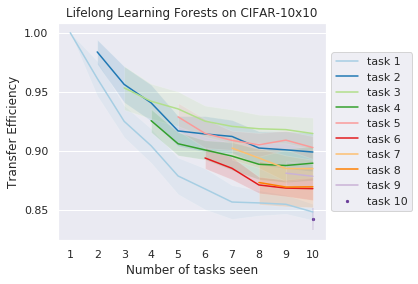

In [150]:
fig, ax = plt.subplots(1,1)

c = sns.color_palette('Paired', n_colors=10)

for i in range(n_tasks-1):
    ax.plot(np.arange(i+1,11), mean_ratios_per_task[i], label = 'task %i'%(i + 1), c=c[i])
    ax.fill_between(np.arange(i+1, 11), 
            mean_ratios_per_task[i] + 1.96*std_ratios_per_task[i]/np.sqrt(mc_its), 
            mean_ratios_per_task[i] - 1.96*std_ratios_per_task[i]/np.sqrt(mc_its), 
            where=mean_ratios_per_task[i] + 1.96*std_ratios_per_task[i]/np.sqrt(mc_its) >= mean_ratios_per_task[i] - 1.96*std_ratios_per_task[i]/np.sqrt(mc_its), 
            facecolor=c[i], 
            alpha=0.15,
            interpolate=True)
    
ax.scatter(10, mean_ratios_per_task[-1], c = c[9], label='task 10', s = 5)
ax.fill_between(10, 
    mean_ratios_per_task[-1] + 1.96*std_ratios_per_task[-1]/np.sqrt(mc_its), 
    mean_ratios_per_task[-1] - 1.96*std_ratios_per_task[-1]/np.sqrt(mc_its), 
    where=mean_ratios_per_task[-1] + 1.96*std_ratios_per_task[-1]/np.sqrt(mc_its) >= mean_ratios_per_task[-1] - 1.96*std_ratios_per_task[-1]/np.sqrt(mc_its), 
    facecolor=c[9], 
    alpha=0.15,
    interpolate=True)
    
ax.set_title('Lifelong Learning Forests on CIFAR-10x10')
ax.set_xlabel('Number of tasks seen')
ax.set_ylabel('Transfer Efficiency')
# ax.set_ylim(0.05 - 0.01, 0.5 + 0.01)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_yticks([1, 0.95, 0.90, 0.85, 0.80])
ax.set_xticks(np.arange(1,11))
ax.grid(axis='x')

plt.errorbar(10, mean_ratios_per_task[-1], yerr=1.96*std_ratios_per_task[-1]/np.sqrt(mc_its),c=c[9],alpha=0.15)

# plt.savefig('cifar-100-TLE-errors.pdf')

In [143]:
mean_ratios_per_task[-1] + 1.96*std_ratios_per_task[-1]/np.sqrt(mc_its), mean_ratios_per_task[-1] - 1.96*std_ratios_per_task[-1]/np.sqrt(mc_its)

(array([0.8516339]), array([0.83226923]))

In [144]:
mean_ratios_per_task[-1]

array([0.84195157])

In [38]:
# pickle.dump(etas, open('estimated_posteriors.pkl', 'wb'))
etas_ = pickle.load(open('estimated_posteriors.pkl', 'rb'))
etas_ = etas

In [73]:
average_etas = [np.zeros((10-i, n_tasks*100, K)) for i in range(n_tasks)]
for i in range(n_tasks):
    for j in range(i, n_tasks):
        average_etas[i][j - i] = np.mean(np.array([etas_[k][i] for k in range(j+1)]), axis=0)

In [74]:
single_accuracies = np.zeros(10)
homogenized_labels = [homogenize_labels(test_labels[t]) for t in test_by_task]
accuracies = [np.zeros((10-i)) for i in range(n_tasks)]
# accuracies = [np.zeros(i + 1) for i in range(n_tasks)]
for i in range(n_tasks):
    for j in range(i, n_tasks):
        accuracies[i][j-i] = np.sum(predict(average_etas[i][j-i]) == homogenized_labels[j])/len(homogenized_labels[j])
    single_accuracies[i] = np.sum(predict(etas_[i][i]) == homogenized_labels[i]) / len(homogenized_labels[i])
        
# new_accs = []
# for i in range(n_tasks):
#     temp = np.zeros(n_tasks - i)
#     for j in range(i, n_tasks):
#         temp[j - i] = accuracies[j][i]
#     new_accs.append(temp)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


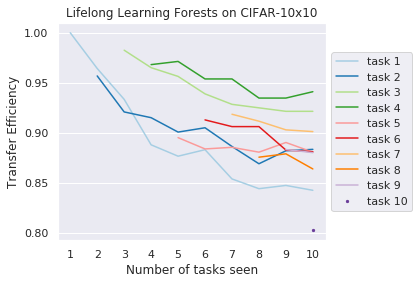

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig, ax = plt.subplots(1,1)
c = sns.color_palette('Paired', n_colors=10)
for i in range(n_tasks - 1):
    ns = np.arange(i + 1, n_tasks + 1)
    ax.plot(ns,(1 - np.array(accuracies[i])) / (1-single_accuracies[i]), label = 'task %i'%(i + 1), c=c[i])
    
ax.scatter(10, (1 - accuracies[-1]) / (1-single_accuracies[-1]), c = c[9], label='task 10', s = 5)
    
ax.set_title('Lifelong Learning Forests on CIFAR-10x10')
ax.set_xlabel('Number of tasks seen')
ax.set_ylabel('Transfer Efficiency')
# ax.set_ylim(0.05 - 0.01, 0.5 + 0.01)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_yticks([1, 0.95, 0.90, 0.85, 0.80])
ax.set_xticks(np.arange(1,11))
ax.grid(axis='x')

plt.savefig('cifar-100-TLE.pdf')

In [69]:
#- Precision
from sklearn.metrics import precision_score

homogenized_labels = [homogenize_labels(test_labels[t]) for t in test_by_task]
precisions = [np.zeros(i + 1) for i in range(n_tasks)]
for i in range(n_tasks):
    for j in range(average_etas[i].shape[0]):
        temp_pred = predict(average_etas[i][j])
        precisions[i][j] = precision_score(homogenized_labels[j], temp_pred, average='macro')
        
new_precisions = []
for i in range(n_tasks):
    temp = np.zeros(n_tasks - i)
    for j in range(i, n_tasks):
        temp[j - i] = precisions[j][i]
    new_precisions.append(temp)

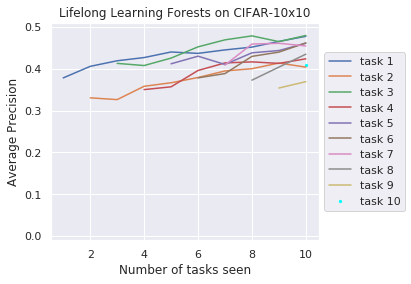

In [77]:
fig, ax = plt.subplots(1,1)
# c = sns.color_palette('rainbow', n_colors=10)
for i in range(n_tasks - 1):
    ns = np.arange(i + 1, n_tasks + 1)
    ax.plot(ns, new_precisions[i], label = 'task %i'%(i + 1))
    
ax.scatter(10, new_precisions[-1], c = 'cyan', label='task 10', s = 5)
    
ax.set_title('Lifelong Learning Forests on CIFAR-10x10')
ax.set_xlabel('Number of tasks seen')
ax.set_ylabel('Average Precision')
ax.set_ylim(0.0 - 0.01, 0.5 + 0.01)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.legend()

plt.savefig('initial-cifar-100-debugged-1-subsample-precision.pdf')

In [54]:
new_precisions, new_accs

([array([0.378, 0.406, 0.418, 0.426, 0.436, 0.432, 0.443, 0.451, 0.465,
         0.476]),
  array([0.336, 0.336, 0.358, 0.366, 0.373, 0.378, 0.388, 0.393, 0.384]),
  array([0.431, 0.425, 0.442, 0.463, 0.465, 0.469, 0.455, 0.464]),
  array([0.354, 0.362, 0.397, 0.408, 0.407, 0.41 , 0.415]),
  array([0.409, 0.43 , 0.412, 0.43 , 0.435, 0.452]),
  array([0.39 , 0.404, 0.44 , 0.449, 0.468]),
  array([0.414, 0.46 , 0.468, 0.464]),
  array([0.386, 0.411, 0.454]),
  array([0.35 , 0.377]),
  array([0.417])],
 [array([0.378, 0.406, 0.418, 0.426, 0.436, 0.432, 0.443, 0.451, 0.465,
         0.476]),
  array([0.336, 0.336, 0.358, 0.366, 0.373, 0.378, 0.388, 0.393, 0.384]),
  array([0.431, 0.425, 0.442, 0.463, 0.465, 0.469, 0.455, 0.464]),
  array([0.354, 0.362, 0.397, 0.408, 0.407, 0.41 , 0.415]),
  array([0.409, 0.43 , 0.412, 0.43 , 0.435, 0.452]),
  array([0.39 , 0.404, 0.44 , 0.449, 0.468]),
  array([0.414, 0.46 , 0.468, 0.464]),
  array([0.386, 0.411, 0.454]),
  array([0.35 , 0.377]),
  array([

In [72]:
#- Recall
from sklearn.metrics import recall_score

homogenized_labels = [homogenize_labels(test_labels[t]) for t in test_by_task]
recalls = [np.zeros(i + 1) for i in range(n_tasks)]
for i in range(n_tasks):
    for j in range(average_etas[i].shape[0]):
        temp_pred = predict(average_etas[i][j])
        recalls[i][j] = recall_score(homogenized_labels[j], temp_pred, average='macro')
        
new_recalls = []
for i in range(n_tasks):
    temp = np.zeros(n_tasks - i)
    for j in range(i, n_tasks):
        temp[j - i] = recalls[j][i]
    new_recalls.append(temp)

In [75]:
new_recalls, new_accs, new_precisions

([array([0.378, 0.406, 0.418, 0.426, 0.436, 0.432, 0.443, 0.451, 0.465,
         0.476]),
  array([0.336, 0.336, 0.358, 0.366, 0.373, 0.378, 0.388, 0.393, 0.384]),
  array([0.431, 0.425, 0.442, 0.463, 0.465, 0.469, 0.455, 0.464]),
  array([0.354, 0.362, 0.397, 0.408, 0.407, 0.41 , 0.415]),
  array([0.409, 0.43 , 0.412, 0.43 , 0.435, 0.452]),
  array([0.39 , 0.404, 0.44 , 0.449, 0.468]),
  array([0.414, 0.46 , 0.468, 0.464]),
  array([0.386, 0.411, 0.454]),
  array([0.35 , 0.377]),
  array([0.417])],
 [array([0.378, 0.406, 0.418, 0.426, 0.436, 0.432, 0.443, 0.451, 0.465,
         0.476]),
  array([0.336, 0.336, 0.358, 0.366, 0.373, 0.378, 0.388, 0.393, 0.384]),
  array([0.431, 0.425, 0.442, 0.463, 0.465, 0.469, 0.455, 0.464]),
  array([0.354, 0.362, 0.397, 0.408, 0.407, 0.41 , 0.415]),
  array([0.409, 0.43 , 0.412, 0.43 , 0.435, 0.452]),
  array([0.39 , 0.404, 0.44 , 0.449, 0.468]),
  array([0.414, 0.46 , 0.468, 0.464]),
  array([0.386, 0.411, 0.454]),
  array([0.35 , 0.377]),
  array([

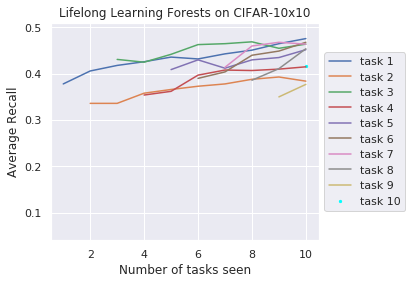

In [78]:
fig, ax = plt.subplots(1,1)
# c = sns.color_palette('rainbow', n_colors=10)
for i in range(n_tasks - 1):
    ns = np.arange(i + 1, n_tasks + 1)
    ax.plot(ns, new_recalls[i], label = 'task %i'%(i + 1))
    
ax.scatter(10, new_recalls[-1], c = 'cyan', label='task 10', s = 5)
    
ax.set_title('Lifelong Learning Forests on CIFAR-10x10')
ax.set_xlabel('Number of tasks seen')
ax.set_ylabel('Average Recall')
ax.set_ylim(0.05 - 0.01, 0.5 + 0.01)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.legend()

plt.savefig('initial-cifar-100-debugged-1-subsample-recall.pdf')